In [1]:
# establishing environment
import warnings
warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from prepare import wrangle_311_data

spark = pyspark.sql.SparkSession.builder.getOrCreate()

# tweak the matplotlib style defaults
plt.rc("figure", figsize=(13, 7))
plt.rc("font", size=14)
plt.style.use("ggplot")

## Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

In [2]:
# wrangling data
df = wrangle_311_data()

In [3]:
# previewing data
df.show(1, vertical=True)

-RECORD 0------------------------------------
 source_id            | svcCRMLS             
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 SLA_due_date         | 9/26/20 0:42         
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 request_address      | 2315  EL PASO ST,... 
 council_district     | 5                    
 case_due_date        | 2020-09-26 00:42:00  
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
 source_username      | svcCRMLS             
only showing top 1 row



### How many different cases are there, by department?

In [4]:
# grouping by department and counting rows
(df.groupBy("department").count()).show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|286287|
|Animal Care Services|119362|
|Trans & Cap Impro...| 97841|
|  Parks & Recreation| 19964|
|    Customer Service|  2889|
|        Metro Health|  5313|
|        City Council|    34|
|DSD/Code Enforcement|323579|
+--------------------+------+



Text(0.5, 0, 'Number of Cases')

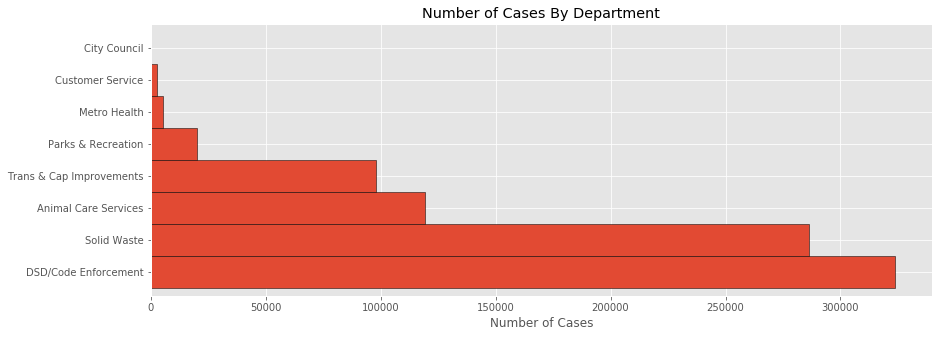

In [5]:
# using code above to aggregate
(
    df.groupBy("department")
    .count()
    # passing to pandas to create plot
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

# setting plot title and axis labels
plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

### Does the percentage of cases that are late vary by department?

In [6]:
#df.groupby('department').count().show()

In [7]:
#df.filter(df.case_late == True).groupby('department').count().show()

### On average, how late are the late cases by department?

In [8]:
# filtering for cases that are currently late
# grouping by department
# aggregating avg number of days late
df.filter(df.case_late == True).groupby('department').agg((mean(df.num_days_late)).alias('avg_days_late')).show()

+--------------------+------------------+
|          department|     avg_days_late|
+--------------------+------------------+
|         Solid Waste| 7.147172789557422|
|Animal Care Services| 23.44672963473822|
|Trans & Cap Impro...| 10.66295045507867|
|  Parks & Recreation|22.427807192724128|
|    Customer Service| 88.18248182589824|
|        Metro Health| 6.494699602827868|
|DSD/Code Enforcement| 49.50633998635033|
+--------------------+------------------+



Text(0, 0.5, 'Department Name')

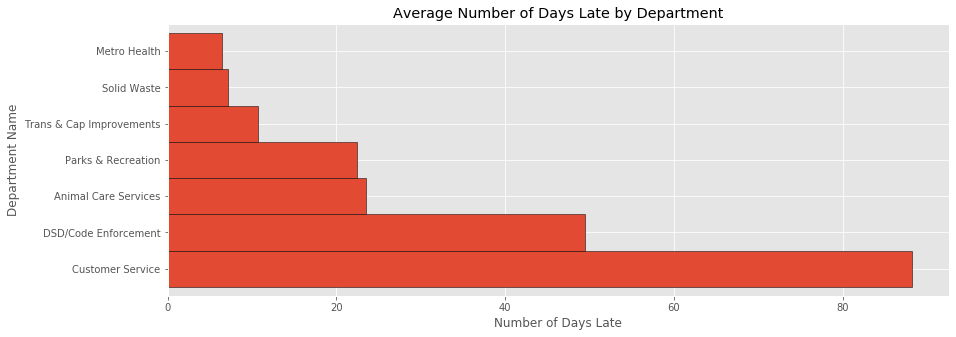

In [9]:
# using code above to aggregate
(
    df.filter(df.case_late == True).groupby('department').agg((mean(df.num_days_late)).alias('avg_days_late'))
    # passing to pandas to create plot
    .toPandas()
    .set_index("department")["avg_days_late"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

# setting plot title and x axis label
plt.title("Average Number of Days Late by Department")
plt.xlabel("Number of Days Late")
plt.ylabel("Department Name")

### What is the service type that is the most late? 

In [10]:
# filtering for cases that are currently late
# grouping by service request type
# aggregating avg number of days late
# observing top 10
df.filter(df.case_late == True).groupby('service_request_type')\
.agg((mean(df.num_days_late)).alias('avg_days_late')).sort(desc('avg_days_late')).show(10)

+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Zoning: Recycle Yard|210.89201994318182|
|  Zoning: Junk Yards|200.20517608494276|
|Structure/Housing...|190.20707698509804|
|Donation Containe...|171.09115313942618|
|Storage of Used M...|163.96812829714287|
|Labeling for Used...|162.43032902285717|
|Record Keeping of...|153.99724039428568|
|Signage Requied f...|151.63868055333333|
|Traffic Signal Gr...|137.64583330000002|
|License Requied U...|128.79828704142858|
+--------------------+------------------+
only showing top 10 rows



Text(0.5, 0, 'Average Number of Days Late')

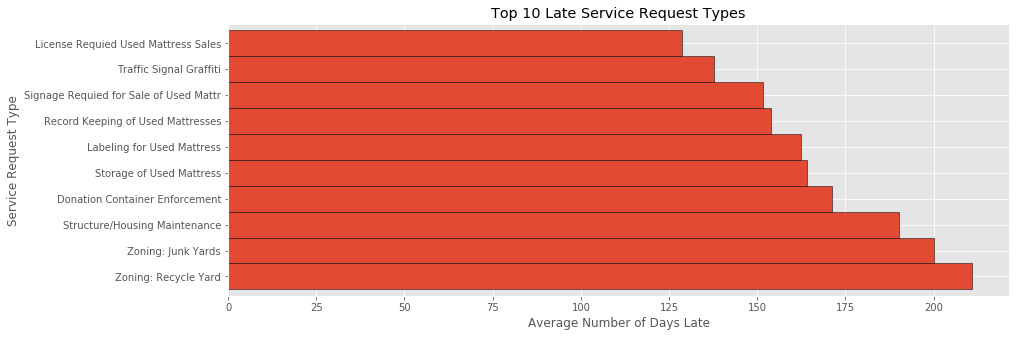

In [11]:
(
    # using code above to aggregate
    df.filter(df.case_late == True).groupby('service_request_type').agg((mean(df.num_days_late)).alias('avg_days_late'))\
    .sort(desc('avg_days_late'))
    # passing to pandas to create plot
    .toPandas()
    .head(10)
    .set_index("service_request_type")["avg_days_late"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

# setting plot title and axis labels
plt.title("Top 10 Late Service Request Types")
plt.ylabel("Service Request Type")
plt.xlabel("Average Number of Days Late")

### Just for Parks & Rec?

In [12]:
# filtering for late cases under the parks and rec dept.
# grouping by service request type
# finding average number of days late 
df.filter(df.case_late == True).filter(df.department == 'Parks & Recreation').groupby('service_request_type')\
.agg((mean(df.num_days_late)).alias('avg_days_late')).sort(desc('avg_days_late')).show()

+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Amenity Park Impr...| 76.60603677123078|
|Major Park Improv...| 75.79450367282352|
|Reservation Assis...|       66.03116319|
|Park Building Mai...| 59.36746980269565|
| Sportfield Lighting|52.034858419575656|
|          Electrical|  42.9519716583451|
|        Tree Removal| 40.28404224560714|
|Landscape Mainten...| 38.86797941326316|
|     Heavy Equipment| 38.56625730831579|
|Miscellaneous Par...| 33.62472491253489|
|Tree Trimming/Mai...|30.563700002936045|
|General Building ...|28.192905974561906|
|             Masonry|27.989420392890622|
|            Painting|25.404551756282608|
|    Sign Maintenance|22.281778663588234|
|   Fence/Gate Repair|20.366796601056606|
|Small Equipment R...|      19.644149305|
|Plumbing/Drinking...| 19.61590306943038|
|               Pools|19.489430630709677|
|            Plumbing|18.621826175298462|
+--------------------+------------

Text(0.5, 0, 'Average Number of Days Late')

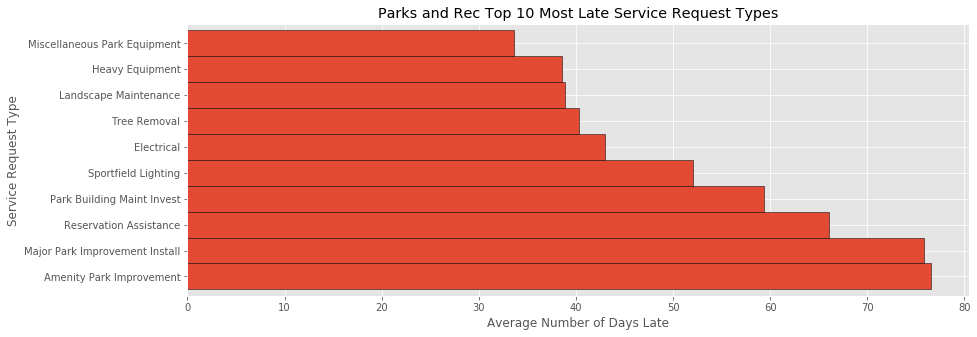

In [13]:
(
    # using code above to aggregate
    df.filter(df.case_late == True).filter(df.department == 'Parks & Recreation').groupby('service_request_type')\
    .agg((mean(df.num_days_late)).alias('avg_days_late')).sort(desc('avg_days_late'))
    # passing to pandas to create plot
    .toPandas()
    .head(10)
    .set_index("service_request_type")["avg_days_late"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

# setting plot title and axis labels
plt.title("Parks and Rec Top 10 Most Late Service Request Types")
plt.ylabel("Service Request Type")
plt.xlabel("Average Number of Days Late")

### For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [14]:
# filtering for dcd/code enforcement 
# grouping by service request type and counting rows per type
df.filter(df.department == 'DSD/Code Enforcement').groupby('service_request_type').count().\
sort(desc('count')).show(5)

+--------------------+-----+
|service_request_type|count|
+--------------------+-----+
|Overgrown Yard/Trash|66403|
|        Bandit Signs|32968|
|Front Or Side Yar...|28920|
|Junk Vehicle On P...|21649|
|Alley-Way Mainten...|20293|
+--------------------+-----+
only showing top 5 rows



Text(0.5, 0, 'Number of Service Requests')

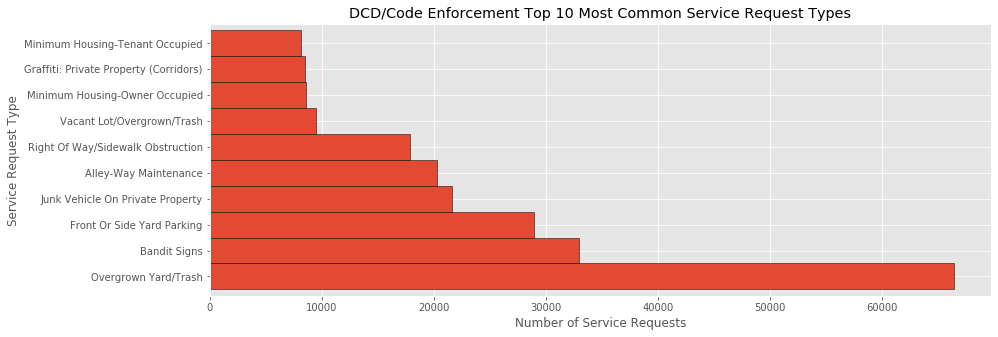

In [15]:
(
    # using code above to aggregate
    df.filter(df.department == 'DSD/Code Enforcement').groupby('service_request_type').count().\
    sort(desc('count'))
    # passing to pandas to create plot
    .toPandas()
    .head(10)
    .set_index("service_request_type")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

# setting plot title and axis labels
plt.title("DCD/Code Enforcement Top 10 Most Common Service Request Types")
plt.ylabel("Service Request Type")
plt.xlabel("Number of Service Requests")

In [16]:
# filtering for metro health department
# grouping by service request type and counting rows per type
df.filter(df.department == 'Metro Health').groupby('service_request_type').count().\
sort(desc('count')).show(5)

+--------------------+-----+
|service_request_type|count|
+--------------------+-----+
|License Renewal I...| 1394|
|  Hygienic Practices|  983|
|               Pests|  737|
|Food Contact Surf...|  606|
| Public Right of Way|  546|
+--------------------+-----+
only showing top 5 rows



Text(0.5, 0, 'Number of Service Requests')

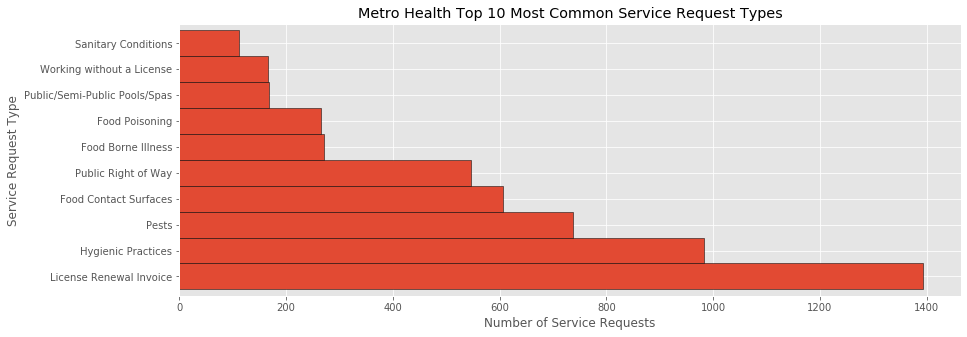

In [17]:
(
    # using code above to aggregate
    df.filter(df.department == 'Metro Health').groupby('service_request_type').count().\
    sort(desc('count'))
    # passing to pandas to create plot
    .toPandas()
    .head(10)
    .set_index("service_request_type")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

# setting plot title and axis labels
plt.title("Metro Health Top 10 Most Common Service Request Types")
plt.ylabel("Service Request Type")
plt.xlabel("Number of Service Requests")

In [18]:
# filtering for city council department
# grouping by service request type and counting rows per type
df.filter(df.department == 'City Council').groupby('service_request_type').count().\
sort(desc('count')).show(5)

+--------------------+-----+
|service_request_type|count|
+--------------------+-----+
|Request for Resea...|   32|
|CCO_Request for R...|    2|
+--------------------+-----+



Text(0.5, 0, 'Number of Service Requests')

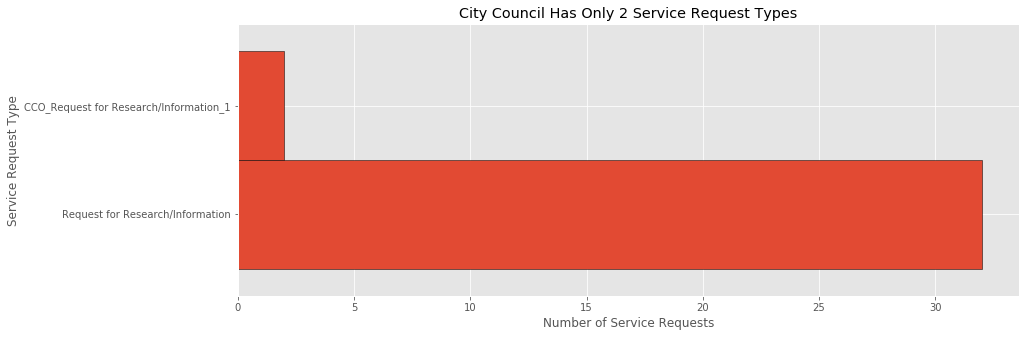

In [19]:
(
    # using code above to aggregate
    df.filter(df.department == 'City Council').groupby('service_request_type').count().\
    sort(desc('count'))
    # passing to pandas to create plot
    .toPandas()
    .head(10)
    .set_index("service_request_type")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

# setting plot title and axis labels
plt.title("City Council Has Only 2 Service Request Types")
plt.ylabel("Service Request Type")
plt.xlabel("Number of Service Requests")

### Does whether or not its a weekend matter for when a case is opened/closed?

In [20]:
df.select('case_opened_date', 'case_closed_date').show()

+-------------------+-------------------+
|   case_opened_date|   case_closed_date|
+-------------------+-------------------+
|2018-01-01 00:42:00|2018-01-01 12:29:00|
|2018-01-01 00:46:00|2018-01-03 08:11:00|
|2018-01-01 00:48:00|2018-01-02 07:57:00|
|2018-01-01 01:29:00|2018-01-02 08:13:00|
|2018-01-01 01:34:00|2018-01-01 13:29:00|
|2018-01-01 06:28:00|2018-01-01 14:38:00|
|2018-01-01 06:57:00|2018-01-02 15:32:00|
|2018-01-01 06:58:00|2018-01-02 15:32:00|
|2018-01-01 06:58:00|2018-01-02 15:32:00|
|2018-01-01 06:59:00|2018-01-02 15:32:00|
|2018-01-01 07:00:00|2018-01-02 15:32:00|
|2018-01-01 07:02:00|2018-01-02 15:32:00|
|2018-01-01 07:02:00|2018-01-02 15:33:00|
|2018-01-01 07:03:00|2018-01-02 15:32:00|
|2018-01-01 07:04:00|2018-01-02 15:33:00|
|2018-01-01 07:04:00|2018-01-02 15:33:00|
|2018-01-01 07:05:00|2018-01-02 15:33:00|
|2018-01-01 07:06:00|2018-01-02 15:33:00|
|2018-01-01 07:06:00|2018-01-02 15:33:00|
|2018-01-01 07:07:00|2018-01-02 15:33:00|
+-------------------+-------------

In [21]:
cases_by_day = df.select(
    "department",
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
    date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date"),
)

cases_by_day.show(5)

+--------------------+----------------+----------------+
|          department|case_opened_date|case_closed_date|
+--------------------+----------------+----------------+
|Animal Care Services|      2018-01-01|      2018-01-01|
|Trans & Cap Impro...|      2018-01-01|      2018-01-03|
|Trans & Cap Impro...|      2018-01-01|      2018-01-02|
|DSD/Code Enforcement|      2018-01-01|      2018-01-02|
|Animal Care Services|      2018-01-01|      2018-01-01|
+--------------------+----------------+----------------+
only showing top 5 rows



In [22]:
# creating DF with department column and case_opened / case_closed columns with updated formatting 
daily_cases = df.select("department", date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),\
date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date"))

# prevewing df
daily_cases.show(5)

+--------------------+----------------+----------------+
|          department|case_opened_date|case_closed_date|
+--------------------+----------------+----------------+
|Animal Care Services|      2018-01-01|      2018-01-01|
|Trans & Cap Impro...|      2018-01-01|      2018-01-03|
|Trans & Cap Impro...|      2018-01-01|      2018-01-02|
|DSD/Code Enforcement|      2018-01-01|      2018-01-02|
|Animal Care Services|      2018-01-01|      2018-01-01|
+--------------------+----------------+----------------+
only showing top 5 rows



In [23]:
# grouping by case opened date, dropping null values, sorting by case opened date
# passing to pandas, converting case opened date to datetime format and setting opened date as index
# counting number of cases opened per date
cases_opened_by_day = (cases_by_day.groupby('case_opened_date').count().na.drop().sort('case_opened_date')\
.toPandas().assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date)).set_index('case_opened_date')\
['count'])

# setting count value column name to cases_opened
cases_opened_by_day.name = 'cases_opened'

# displaying series
cases_opened_by_day

case_opened_date
2017-01-01     155
2017-01-02    1443
2017-01-03    1813
2017-01-04    1647
2017-01-05    1841
              ... 
2018-08-04     688
2018-08-05     350
2018-08-06    2116
2018-08-07    2455
2018-08-08     604
Name: cases_opened, Length: 585, dtype: int64

In [24]:
# grouping by case closed date, dropping null values, sorting by case closed date
# passing to pandas, converting case opened date to datetime format and setting closed date as index
# counting number of cases closed per date
cases_closed_by_day = (cases_by_day.groupby('case_closed_date').count().na.drop().sort('case_closed_date')\
.toPandas().assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date)).set_index('case_closed_date')
['count'])

# setting count value column name to cases_closed
cases_closed_by_day.name = 'cases_closed'

# displaying series
cases_closed_by_day

case_closed_date
2017-01-01      67
2017-01-02     390
2017-01-03     757
2017-01-04    1247
2017-01-05    1199
              ... 
2018-08-04     756
2018-08-05     216
2018-08-06    1749
2018-08-07    2137
2018-08-08     693
Name: cases_closed, Length: 585, dtype: int64

In [25]:
# combining series to create pandas DF 
open_close_df = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)

# displaying df
open_close_df

,cases_opened,cases_closed
2017-01-01,155,67
2017-01-02,1443,390
2017-01-03,1813,757
2017-01-04,1647,1247
2017-01-05,1841,1199
...,...,...
2018-08-04,688,756
2018-08-05,350,216
2018-08-06,2116,1749
2018-08-07,2455,2137


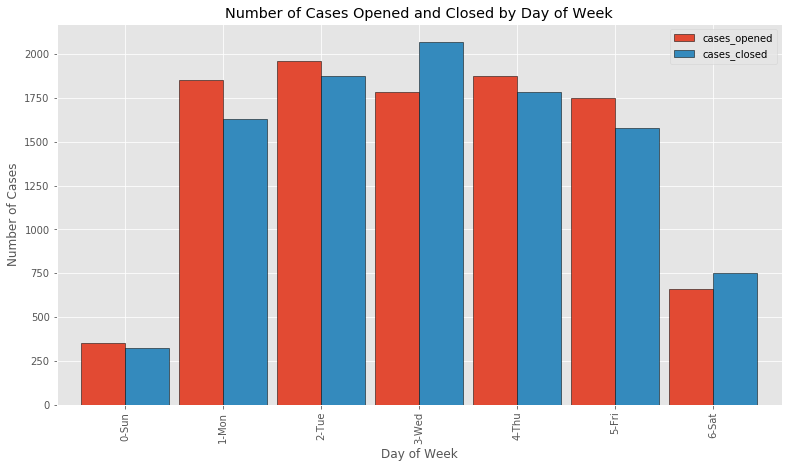

In [26]:
# creating new column, weekday, that displays the day of the week for each close date
open_close_df['weekday'] = open_close_df.index.strftime('%w-%a')

# grouping by weekday, aggregating average, creating plot
open_close_df.groupby('weekday').mean().plot.bar(figsize=(13, 7), ec='black', width=.9)

# setting axis labels and plot title
plt.title('Number of Cases Opened and Closed by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Cases')

# displaying plot
plt.show()

### On average, how many cases are opened a day for the Customer Service department?

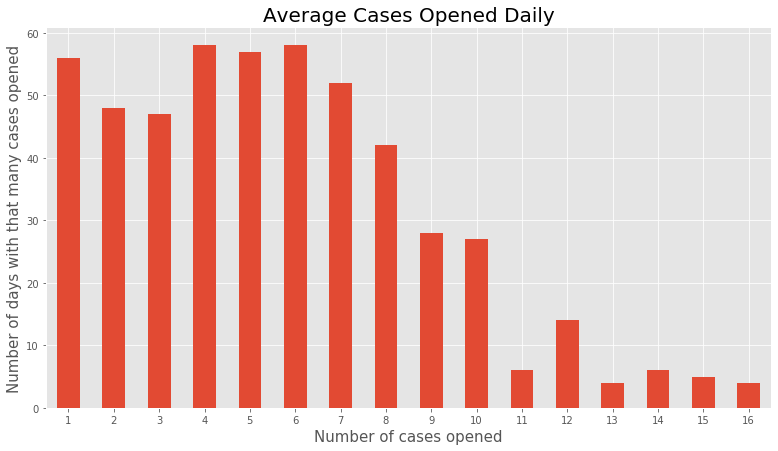

In [50]:
# creating function to plot cases per day
def plot_cases(df):
    # isolating count column
    s = df["count"]
    # getting average of count 
    avg = s.mean()
    # getting counts of each unique value in count 
    # sorting index and creating plot 
    s.value_counts().sort_index().plot.bar()
    # setting title, axis labels and xticks
    plt.title(f"Average Cases Opened Daily", size=20)
    plt.xlabel("Number of cases opened", size = 15)
    plt.ylabel("Number of days with that many cases opened", size = 15)
    plt.xticks(rotation=0)


(
    # isolating date from case_opened_date 
    df.withColumn("case_opened_date", expr("date(case_opened_date)"))
    # filtering for customer service dept.
    .filter(df.department == "Customer Service")
    # grouping by case_opened_date
    .groupby("case_opened_date")
    # counting cases opened on each date
    .count()
    # passing to pandas
    .toPandas()
    # passing df to function above
    .pipe(plot_cases)
)

### Does the number of service requests for the solid waste department vary by day of the week?

Text(0.5, 1.0, 'Solid Waste Department Service Request Variance by Day of Week')

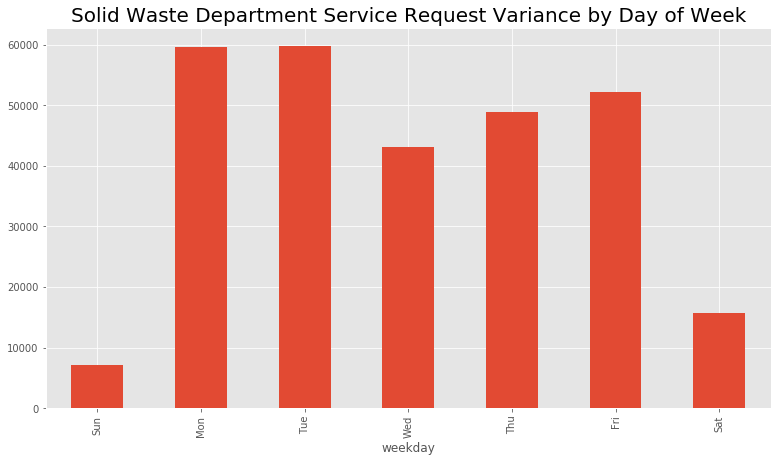

In [72]:
# setting weekdays as list 
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

(
    # adding weekday column by extracting day from case opened date
    df.withColumn("weekday", date_format("case_opened_date", "E"))
    # filter for solid waste department rows
    .filter(expr('department == "Solid Waste"'))
    # group by weekday
    .groupby("weekday")
    # count number of requests per weekday
    .count()
    # drop nulls
    .na.drop()
    # pass to pandas
    .toPandas()
    # bin each count into weekdays
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    # set and sort index
    .set_index('weekday')['count']
    .sort_index()
    # plot data
    .plot.bar()
)

# set plot title
plt.title('Solid Waste Department Service Request Variance by Day of Week', size = 20)